# Recurrent Neural Network - Word Classification
## Using Seq2Seq model
Implemented in TensorFlow. Using bidirectual RNN as encoder and decoder implemented as tf.nn.raw_rnn
## TODO
```
Overlaping sliders
One-shot preprocessing
Implement as android app
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import tensorflow as tf
from tensorflow.python.ops.rnn_cell_impl import LSTMCell, ResidualWrapper, DropoutWrapper, MultiRNNCell
import tensorflow.contrib.seq2seq as seq2seq
from tensorflow.python.layers import core as layers_core
import time

from ocr.datahelpers import loadWordsData, correspondingShuffle
from ocr.mlhelpers import TrainingPlot
from ocr.tfhelpers import Graph

%matplotlib notebook
# Increase size of images
plt.rcParams['figure.figsize'] = (9.0, 5.0)

tf.reset_default_graph()
sess = tf.InteractiveSession()
print('Tensorflow', tf.__version__)

Tensorflow 1.2.1


### Loading images

In [2]:
images, labels = loadWordsData(['data/words/', 'data/words_nolines/'],
                               loadGaplines=False)

Loading words...
Number of Images: 1166


In [3]:
CHARS = ['A', 'a', 'Á', 'á', 'B', 'b', 'C', 'c', 'Č', 'č',
         'D', 'd', 'Ď', 'ď', 'E', 'e', 'É', 'é', 'Ě', 'ě',
         'F', 'f', 'G', 'g', 'H', 'h', 'I', 'i', 'Í', 'í',         
         'J', 'j', 'K', 'k', 'L', 'l', 'M', 'm', 'N', 'n',
         'Ň', 'ň', 'O', 'o', 'Ó', 'ó', 'P', 'p', 'Q', 'q',
         'R', 'r', 'Ř', 'ř', 'S', 's', 'Š', 'š', 'T', 't',
         'Ť', 'ť', 'U', 'u', 'Ú', 'ú', 'Ů', 'ů', 'V', 'v',
         'W', 'w', 'X', 'x', 'Y', 'y', 'Ý', 'ý', 'Z', 'z',
         'Ž', 'ž']

char_size = len(CHARS)
print("Number of chars:", char_size)

Number of chars: 82


## Settings

In [4]:
PAD = 0   # Padding
EOS = 1   # End of seq

num_buckets = 5
slider_size = (60, 30)
N_INPUT = 8*15*50                  # Size of sequence input vector
vocab_size = char_size + 2         # Number of different chars + <PAD> and <EOS>
input_embedding_size = vocab_size  # Size of vector for embedding chars2vec


encoder_layers = 2
decoder_layers = 2*encoder_layers  # 2* is due to the bidirectional encoder
encoder_residual_layers = 1        # HAVE TO be smaller than encoder_layers
decoder_residual_layers = 2*encoder_residual_layers
encoder_units = 128
decoder_units = encoder_units

learning_rate = 1e-4               # 1e-4
max_gradient_norm = 5.0            # For gradient clipping
dropout = 0.2
train_per = 0.8                    # Percentage of training data

TRAIN_STEPS = 100000               # Number of training steps!
TEST_ITER = 150
LOSS_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 64
EPOCH = 1000                       # Number of batches in epoch - not accurate

# Function for preprocessing images
graph = Graph('models/gap-clas/CNN-CG',
              operation='h_conv2_flat')
def imgPreprocessor(x):
    # Cut returned data to N_INPUT size - no need for everything
    return graph.run(np.reshape(x, (1, 1800)))[0][:N_INPUT]

INFO:tensorflow:Restoring parameters from models/gap-clas/CNN-CG


## Dataset

In [5]:
# Shuffle data for later splitting
images, labels = correspondingShuffle(images, labels)

idxs = [i+2 for i in range(char_size)]
idx_to_chars = dict(zip(idxs, CHARS))
chars_to_idx = dict(zip(CHARS, idxs))

labels_idx = np.empty(len(labels), dtype=object)
for i, label in enumerate(labels):
    labels_idx[i] = [chars_to_idx[c] for c in label]

# Split data on train and test dataset
div = int(0.80 * len(images))

trainImages = images[0:div]
testImages = images[div:]

trainLabels_idx = labels_idx[0:div]
testLabels_idx = labels_idx[div:]

print("Training images:", div)
print("Testing images:", len(images) - div)

Training images: 932
Testing images: 234


In [6]:
class BucketDataIterator():
    """ Iterator for feeding seq2seq model during training """
    def __init__(self,
                 images,
                 targets,
                 num_buckets=5,
                 slider=(60, 30),
                 imgprocess=lambda x: x,
                 train=True):
        
        self.train = train
        
        # First PADDING of images to slider size ( -(a // b) ==  ceil(a/b))
        self.slider = slider
        for i in images:
            i.resize((i.shape[0], -(-i.shape[1] // slider[1]) * slider[1]),
                     refcheck=False)
        in_length = [image.shape[1]//slider[1] for image in images]
        
        # Split images to sequence of vectors
        imgseq = np.empty(len(images), dtype=object)
        for i, img in enumerate(images):
            imgseq[i] = [imgprocess(img[:, loc * slider[1]: (loc+1) * slider[1]].flatten())
                         for loc in range(in_length[i])]

        # Create pandas dataFrame and sort it by images width (length) 
        self.dataFrame = pd.DataFrame({'in_length': in_length,
                                       'out_length': [len(t) for t in targets],
                                       'images': imgseq,
                                       'targets': targets
                                      }).sort_values('in_length').reset_index(drop=True)

        bsize = int(len(images) / num_buckets)
        self.num_buckets = num_buckets
        
        # Create buckets by slicing parts by indexes
        self.buckets = []
        for bucket in range(num_buckets-1):
            self.buckets.append(self.dataFrame.iloc[bucket * bsize: (bucket+1) * bsize])
        self.buckets.append(self.dataFrame.iloc[(num_buckets-1) * bsize:])        
        
        self.buckets_size = [len(bucket) for bucket in self.buckets]

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.bucket_order = np.random.permutation(num_buckets)
        self.bucket_cursor = 0
        self.shuffle()
        print("Iterator created.")

    def shuffle(self, idx=None):
        """ Shuffle idx bucket or each bucket separately """
        for i in [idx] if idx is not None else range(self.num_buckets):
            self.buckets[i] = self.buckets[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0


    def next_batch(self, batch_size):
        """
        Creates next training batch of size: batch_size
        Retruns: image seq, letter seq,
                 image seq lengths, letter seq lengths
        """
        i_bucket = self.bucket_order[self.bucket_cursor]
        # Increment cursor and shuffle in case of new round
        self.bucket_cursor = (self.bucket_cursor + 1) % self.num_buckets
        if self.bucket_cursor == 0:
            self.bucket_order = np.random.permutation(self.num_buckets)
            
        if self.cursor[i_bucket] + batch_size > self.buckets_size[i_bucket]:
            self.shuffle(i_bucket)

        # Handle too big batch sizes
        if (batch_size > self.buckets_size[i_bucket]):
            batch_size = self.buckets_size[i_bucket]

        res = self.buckets[i_bucket].iloc[self.cursor[i_bucket]:
                                          self.cursor[i_bucket]+batch_size]
        self.cursor[i_bucket] += batch_size

        # PAD input sequence and output
        # Pad sequences with <PAD> to same length
        input_max = max(res['in_length'])
        output_max = max(res['out_length'])
        assert input_max + 10 >= output_max   # In order to make it work at production
        
        input_seq = np.zeros((batch_size, input_max, N_INPUT), dtype=np.float32)
        for i, img in enumerate(res['images']):
            input_seq[i][:res['in_length'].values[i]] = img
        input_seq = input_seq.swapaxes(0, 1)
        
        # Need to pad according to the maximum length output sequence
        targets = np.zeros([batch_size, output_max], dtype=np.int32)
        for i, target in enumerate(targets):
            target[:res['out_length'].values[i]] = res['targets'].values[i]
        targets = targets.swapaxes(0, 1)
        
        return input_seq, targets, res['in_length'].values, res['out_length'].values
    
    def next_feed(self, size):
        """ Create feed directly for model training """
        (encoder_inputs_,
         decoder_targets_,
         encoder_inputs_length_,
         decoder_targets_length_) = self.next_batch(size)
        return {
            encoder_inputs: encoder_inputs_,
            encoder_inputs_length: encoder_inputs_length_,
            decoder_targets: decoder_targets_,
            decoder_targets_length: decoder_targets_length_,
            keep_prob: 1.0 - dropout if self.train else 1.0
        }

In [7]:
# Create iterator for feeding RNN
# Create only once, it modifies: labels_idx
train_iterator = BucketDataIterator(trainImages,
                                    trainLabels_idx,
                                    num_buckets,
                                    slider_size,
                                    imgPreprocessor,
                                    train=True)
test_iterator = BucketDataIterator(testImages,
                                   testLabels_idx,
                                   num_buckets,
                                   slider_size,
                                   imgPreprocessor,
                                   train=False)

Iterator created.
Iterator created.


## Placeholders

In [8]:
# Input placehodlers
# N_INPUT -> size of vector representing one image in sequence
# Encoder inputs shape (max_seq_length, batch_size, vec_size)
encoder_inputs = tf.placeholder(shape=(None, None, N_INPUT),
                                dtype=tf.float32,
                                name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,),
                                       dtype=tf.int32,
                                       name='encoder_inputs_length')
# required for training, not required for testing and application
decoder_targets = tf.placeholder(shape=(None, None),
                                 dtype=tf.int32,
                                 name='decoder_targets')
decoder_targets_length = tf.placeholder(shape=(None,),
                                        dtype=tf.int32,
                                        name='decoder_targets_length')
# Dropout value
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### Decoder Train Feeds

In [9]:
sequence_size, batch_size = tf.unstack(tf.shape(decoder_targets))

EOS_SLICE = tf.ones([1, batch_size], dtype=tf.int32) * EOS
PAD_SLICE = tf.ones([1, batch_size], dtype=tf.int32) * PAD

# Train inputs with EOS symbol at start of seq
decoder_train_inputs = tf.concat([EOS_SLICE, decoder_targets], axis=0)
decoder_train_length = decoder_targets_length + 1

# train targets with EOS symbol at end of seq
decoder_train_targets = tf.concat([decoder_targets, PAD_SLICE], axis=0)
decoder_train_targets_seq_len, _ = tf.unstack(tf.shape(decoder_train_targets))
decoder_train_targets_eos_mask = tf.one_hot(decoder_train_length - 1,
                                            decoder_train_targets_seq_len,
                                            on_value=EOS, off_value=PAD,
                                            dtype=tf.int32)
decoder_train_targets_eos_mask = tf.transpose(decoder_train_targets_eos_mask, [1, 0])

# hacky way using one_hot to put EOS symbol at the end of target sequence
decoder_train_targets = tf.add(decoder_train_targets,
                               decoder_train_targets_eos_mask)

# Pad test accuracy
# TODO With APIr1.3 can add properti: constant_values=PAD
decoder_test_targets = tf.pad(
    decoder_train_targets,
    [[0, tf.reduce_max(encoder_inputs_length) + 10 - decoder_train_targets_seq_len], [0, 0]],
    mode='CONSTANT')

loss_weights = tf.sequence_mask(
    decoder_train_length,
    tf.reduce_max(decoder_train_length),
    dtype=tf.float32)

test_weights = tf.sequence_mask(
    decoder_train_length,
    tf.reduce_max(encoder_inputs_length) + 10,
    dtype=tf.float32)

### Embeddings

In [10]:
# Randomly initialized embedding matrix, for characters embedding in decoder
embeddings = tf.Variable(tf.random_uniform([vocab_size,
                                            input_embedding_size],
                                           -1.0, 1.0),
                         dtype=tf.float32)

decoder_train_inputs_embedded = tf.nn.embedding_lookup(
    embeddings, decoder_train_inputs)

## Cell creator

In [11]:
def create_single_cell(cell_fn, num_units, is_residual=False, is_dropout=False):
    """ Create single RNN cell based on cell_fn"""
    cell = cell_fn(num_units)
    if is_dropout:
        cell = DropoutWrapper(cell, input_keep_prob=keep_prob)
    if is_residual:
        cell = ResidualWrapper(cell)
    return cell

def create_cell(num_units, num_layers, num_residual_layers, is_dropout=False, cell_fn=LSTMCell):
    """ Create corresponding number of RNN cells with given wrappers"""
    cell_list = []
    
    for i in range(num_layers):
        cell_list.append(create_single_cell(
            cell_fn=cell_fn,
            num_units=num_units,
            is_residual=(i >= num_layers - num_residual_layers),
            is_dropout=is_dropout
        ))

    if num_layers == 1:
        return cell_list[0]
    return MultiRNNCell(cell_list)

## Encoder

In [12]:
enc_cell_fw = create_cell(encoder_units,
                          encoder_layers,
                          encoder_residual_layers,
                          is_dropout=True)
enc_cell_bw = create_cell(encoder_units,
                          encoder_layers,
                          encoder_residual_layers,
                          is_dropout=True)

In [13]:
# Bidirectional RNN, gibe fw and bw outputs separately
enc_outputs, enc_state = tf.nn.bidirectional_dynamic_rnn(
    cell_fw = enc_cell_fw,
    cell_bw = enc_cell_bw,
    inputs = encoder_inputs,
    sequence_length = encoder_inputs_length,
    dtype = tf.float32,
    time_major = True)

encoder_outputs = tf.concat(enc_outputs, -1)

if encoder_layers == 1:
    encoder_state = enc_state
else:
    encoder_state = []
    for layer_id in range(encoder_layers):
        encoder_state.append(enc_state[0][layer_id])  # forward
        encoder_state.append(enc_state[1][layer_id])  # backward
    encoder_state = tuple(encoder_state)

In [14]:
sess.run(tf.global_variables_initializer())
fd  = test_iterator.next_feed(5)
print(loss_weights.eval(fd))

[[ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]]


## Decoder

In [15]:
# attention_states: size [batch_size, max_time, num_units]
attention_states = tf.transpose(encoder_outputs, [1, 0, 2])

# Create an attention mechanism
attention_mechanism = tf.contrib.seq2seq.LuongAttention(
    decoder_units, attention_states,
    memory_sequence_length=encoder_inputs_length)


decoder_cell = create_cell(decoder_units,
                           decoder_layers,
                           decoder_residual_layers,
                           is_dropout=True)

decoder_cell = seq2seq.AttentionWrapper(
    decoder_cell, attention_mechanism,
    attention_layer_size=decoder_units)

decoder_initial_state = decoder_cell.zero_state(batch_size, tf.float32).clone(
    cell_state=encoder_state)

### TRAIN DECODER ###
# Helper
helper = seq2seq.TrainingHelper(
    decoder_train_inputs_embedded, decoder_train_length, time_major=True)

# Decoder
projection_layer = layers_core.Dense(
    vocab_size, use_bias=False)

decoder = seq2seq.BasicDecoder(
    decoder_cell, helper, decoder_initial_state,
    output_layer=projection_layer)

# Dynamic decoding
# outputs.rnn_output   = plain output
# outputs.sample_id = tf.argmax(outputs.rnn_output, axis=-1)
outputs, final_context_state, _ = seq2seq.dynamic_decode(
    decoder)

logits_train = outputs.rnn_output
prediction_train = outputs.sample_id

# Add reuse variables ???

### INFERENCE DECODER ###
# Helper
helper_infer = seq2seq.GreedyEmbeddingHelper(
    embeddings,
    tf.fill([batch_size], EOS), EOS)

# Decoder
decoder_infer = seq2seq.BasicDecoder(
    decoder_cell, helper_infer, decoder_initial_state,
    output_layer=projection_layer)

# Dynamic decoding
outputs_infer, final_context_state, final_seq_lengths = seq2seq.dynamic_decode(
    decoder_infer,
    impute_finished=True,
    maximum_iterations=tf.reduce_max(encoder_inputs_length) + 10)
prediction_inference = outputs_infer.sample_id

### Optimizer

In [16]:
targets = tf.transpose(decoder_train_targets, [1, 0])
test_targets = tf.transpose(decoder_test_targets, [1, 0])
## Loss
loss = seq2seq.sequence_loss(logits=logits_train, targets=targets, weights=loss_weights)

## Calculate and clip gradients
params = tf.trainable_variables()
gradients = tf.gradients(loss, params)
clipped_gradients, _ = tf.clip_by_global_norm(
    gradients, max_gradient_norm)

### Optimization
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.apply_gradients(
    zip(clipped_gradients, params))


### Evaluate model
# Pad prediction to match lengths
# TODO With APIr1.3 can add properti: constant_values=PAD
prediction_infer_padded = tf.pad(
    prediction_inference,
    [[0, 0], [0, tf.reduce_max(encoder_inputs_length) + 10 - tf.reduce_max(final_seq_lengths)]],
    mode='CONSTANT')

correct_prediction = tf.equal(prediction_infer_padded,
                              test_targets)
## Advanced accuracy only the elements of seq including EOS symbol
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy = tf.reduce_sum(tf.cast(correct_prediction, tf.float32)*test_weights)/tf.reduce_sum(test_weights)

## Training

<IPython.core.display.Javascript object>


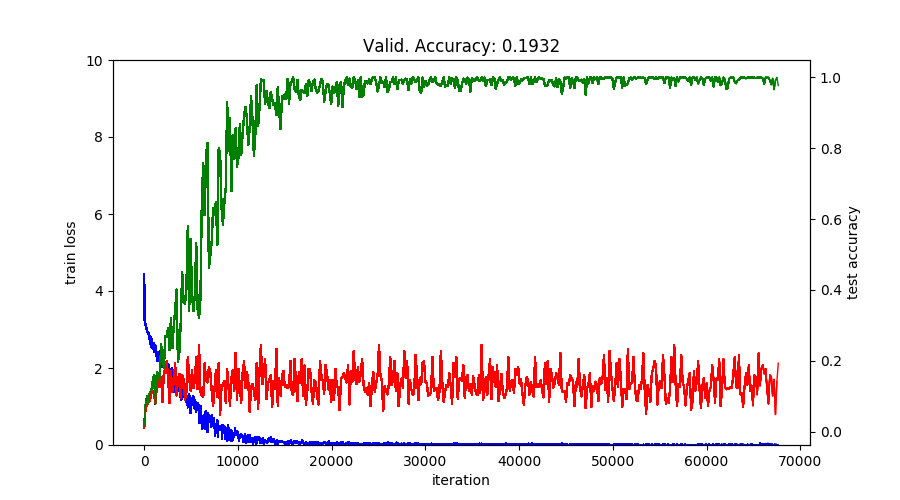

batch 0 - loss: 4.4897556
    expected  > [61  3 35  1  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [13 13 13 13 13 55 55 55 12 12 12 27 33 33 33]
    expected  > [17 71 53 45 49  3 41 19  1  0  0  0  0  0  0]
    predicted > [83 83 83 83 83 83 83 83 83 83 11 11 83 11 83]

batch 1000 - loss: 2.7773352
    expected  > [40  3 15  3  1  0  0  0  0  0  0  0  0  0  0]
    predicted > [61  3 35  1  0  0  0  0  0  0  0  0  0  0  0]
    expected  > [61 17 49  1  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [49 45  1  0  0  0  0  0  0  0  0  0  0  0  0]

batch 2000 - loss: 2.7763758
    expected  > [71  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [41 45  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
    expected  > [65 81 41  3 37 17  1  0  0  0  0  0  0  0  0  0]
    predicted > [39  3 57 61  3  1  0  0  0  0  0  0  0  0  0  0]

batch 3000 - loss: 2.9190035
    expected  > [41 31  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [61 65  1  0  0  0  0  0  0  0  0 

batch 28000 - loss: 7.694066
    expected  > [ 8 61 29  7 45 53  1  0  0  0  0  0  0  0  0  0]
    predicted > [63 65 35  3  1  0  0  0  0  0  0  0  0  0  0  0]
    expected  > [71 37 29 71 69  1  0  0  0  0  0  0  0  0  0  0]
    predicted > [45 41  3  1  0  0  0  0  0  0  0  0  0  0  0  0]

batch 29000 - loss: 7.3323388
    expected  > [12 45 39 29 41 29 35  3  1  0  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [57 57 61  3  7  7 45  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
    expected  > [53 65  9 17  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [ 9 45 41  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

batch 30000 - loss: 7.1920786
    expected  > [71 69 81  1  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [81  5  7  1  0  0  0  0  0  0  0  0  0  0  0]
    expected  > [ 9 45  1  0  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [45  1  0  0  0  0  0  0  0  0  0  0  0  0  0]

batch 31000 - loss: 6.9821892
    expected  > [12  3 41 29 17 37  1 

batch 57000 - loss: 8.4669542
    expected  > [ 9 27 37  3 13 41 79 39 29  1  0  0  0  0  0  0]
    predicted > [40  3 57 45 39 17 33 31  1  0  0  0  0  0  0  0]
    expected  > [ 8 61 29  7 45 53  1  0  0  0  0  0  0  0  0  0]
    predicted > [16 71  3 41  1  0  0  0  0  0  0  0  0  0  0  0]

batch 58000 - loss: 6.8507161
    expected  > [71 77  1  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [70  1  0  0  0  0  0  0  0  0  0  0  0  0]
    expected  > [40  3  1  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [61  3  1  0  0  0  0  0  0  0  0  0  0  0]

batch 59000 - loss: 8.4460182
    expected  > [61 71  5  1  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [57  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
    expected  > [65  7  3 37  1  0  0  0  0  0  0  0  0  0  0]
    predicted > [59 17 43  1  0  0  0  0  0  0  0  0  0  0  0]

batch 60000 - loss: 7.0306044
    expected  > [33 17 33 29  9 27  1  0  0  0  0  0  0  0]
    predicted > [33 17 61  1  0  0  0  0  0  0  0  0  0  0]
 

In [ ]:
sess.run(tf.global_variables_initializer())


# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, LOSS_ITER)

try:
    for i_batch in range(TRAIN_STEPS):
        fd = train_iterator.next_feed(BATCH_SIZE)
        train_step.run(fd)
        
        if i_batch % LOSS_ITER == 0:
            # Plotting loss
            tmpLoss = loss.eval(fd)
            trainPlot.updateCost(tmpLoss, i_batch // LOSS_ITER)
    
        if i_batch % TEST_ITER == 0:
            # Plotting accuracy
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            accTest = accuracy.eval(fd_test)
            accTrain = accuracy.eval(fd)
            trainPlot.updateAcc(accTest, accTrain, i_batch // TEST_ITER)

        if i_batch % SAVE_ITER == 0:
            # TODO Implement saver
            pass
        
        if i_batch % EPOCH == 0:
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            print('batch %r - loss: %r' % (i_batch, sess.run(loss, fd_test)))
            predict_, target_ = sess.run([prediction_infer_padded, test_targets], fd_test)
            for i, (inp, pred) in enumerate(zip(target_, predict_)):
                print('    expected  > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 1:
                    break
            print()

except KeyboardInterrupt:
    # TODO add saving on interrup
    print('Training interrupted.')